## How to Quickly Design Advanced Sklearn Pipelines
- https://towardsdatascience.com/how-to-quickly-design-advanced-sklearn-pipelines-3cc97b59ce16

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div>
<div style="text-align: right"> Initial upload: 2023.7.9</div>
<div style="text-align: right"> Last update: 2023.7.10</div>

In [1]:
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
from scipy import stats
import warnings; warnings.filterwarnings('ignore')
#plt.style.use('ggplot')
plt.style.use('seaborn-whitegrid')
%matplotlib inline

파이프라인 구성을 위하 다음 컴포넌트드를 사용할 수 있다.  
- TransformerMixin
- BaseEstimator
- FunctionTransformer
- ColumnTransformer
- FeatureUnion
- TransformedTargetRegressor

여기서는 파이프라인으로 forecasting 모델을 구축해본다.

In [2]:
import glob
import re
import os
import logging
import xarray as xr

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import make_column_transformer, TransformedTargetRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
from sklearn.pipeline import make_pipeline, make_union, Pipeline
from sklearn.preprocessing import FunctionTransformer, MinMaxScaler

from functools import partial
from typing import Optional, Union, Tuple

여기서는 print 대신 logging을 사용해본다.   
그리고 logging 레벨을 logging.DEBUG로 설정한다.

In [3]:
logging.basicConfig(level=logging.DEBUG)

logger = logging.getLogger("sklearn-pipelines")
logger.info("Logger configured")

INFO:sklearn-pipelines:Logger configured


In [4]:
NUM_OBSERVED_POINTS: int = 5
SIZE_TEST_SPLIT: int = 4

데이터 추출
- xarray 사용 위해 pip install netcdf4 h5netcdf 필요

In [5]:
def extract(root_dir: str) -> pd.DataFrame:
    """Function that takes the root dir of a plant (e.g., wheat, maize, etc.) and extracts everything into a DataFrame."""

    year_yields = {}
    for file_path in glob.glob(os.path.join(root_dir, "*.nc4")):
        file_name = os.path.split(file_path)[1]
        year_match = re.match(r"^yield_(\d+?)\.nc4$", file_name)
        year = year_match.group(1)
        year = int(year)

        ds = xr.open_dataset(file_path)
        df = ds.to_dataframe()
        mean_year_value = df.mean().iloc[0]

        year_yields[year] = {
            "mean_yield": mean_year_value,
            "locations": len(df.dropna())
        }

    year_yields = pd.DataFrame.from_dict(data=year_yields, orient='index')
    year_yields = year_yields.sort_index()

    return year_yields

In [6]:

yields = extract("data/yields/wheat")

In [7]:
yields.head()

,mean_yield,locations
1981,1.678322,2346
1982,3.048540,12628
1983,3.226099,12641
1984,3.340139,12627
1985,3.297000,12624


In [8]:
yields.shape

(36, 2)

DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/sguys99/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymReg.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/sguys99/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(FontEntry(fname='/home/sguys99/anaconda3/lib/python3.10/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
DEBUG:matplotlib.font_manager

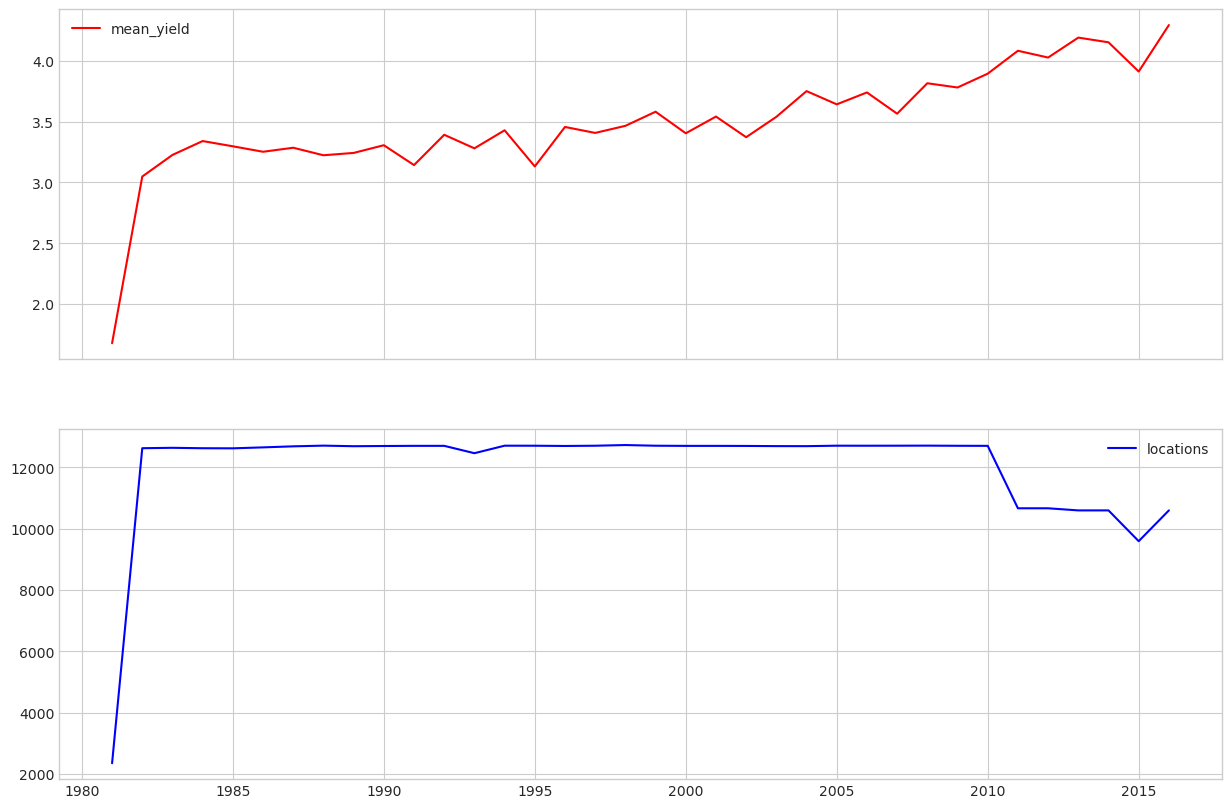

In [9]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (15, 10), sharex=True)
yields['mean_yield'].plot(ax = ax1, color='r', label = 'mean_yield')
yields['locations'].plot(ax = ax2, color = 'b', label = 'locations')
ax1.legend()
ax2.legend()

### Data preprocessing
현재 데이터셋으로부터 피처와 레이블을 추출하는 것부터 시작해야한다.   
피처는 시계열 데이터의 과거 피처를 가져온 것이다.

In [10]:
X, y = yields.copy(), yields.copy()

split data

In [11]:
class TimeSeriesSplitter:
    """The class is used to split the time series between train and split and stores the indices for future reconstruction."""

    def __init__(self, num_observed_points: int):
        """

        Args:
            num_observed_points: The number of observed points from the past that are used to forecast the future.
        """

        self.num_observed_points = num_observed_points

        self.X_train: Optional[pd.DataFrame] = None
        self.y_train: Optional[pd.DataFrame] = None
        self.X_test: Optional[pd.DataFrame] = None
        self.y_test: Optional[pd.DataFrame] = None


    def split(self, X: pd.DataFrame, y: pd.DataFrame, test_num_years: int = 5) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
        """Split the data between train and test."""

        start_train_num_years = X.index.min()
        end_train_num_years = X.index.max() - test_num_years
        assert end_train_num_years > 0, "The number of training months is 0."


        X_train_mask = X.index <= end_train_num_years
        y_train_mask = (y.index >= start_train_num_years + self.num_observed_points) & (y.index <= end_train_num_years) # Remove self.num_observed_points from the target, because we cannot predict those items due to lack of data. We need at least self.num_observed_points to forecast.
        X_test_mask = X.index > end_train_num_years - (self.num_observed_points + 1)  # Add self.num_observed items to the features so we can forecast the first element from the future based on what we know. Also add another +1 element for the differentiation operation.
        y_test_mask = y.index > end_train_num_years - 1 # Subtract -1 for the differentiation operation.

        self.X_train = X.loc[X_train_mask]
        self.y_train = y.loc[y_train_mask]["mean_yield"]

        self.X_test = X.loc[X_test_mask]
        self.y_test = y.loc[y_test_mask]["mean_yield"]

        return self.X_train, self.y_train, self.X_test, self.y_test

    def attach_indices(self, y: Union[pd.Series, np.ndarray], split: str = "test") -> pd.Series:
        """Take the predictions of the model and attach the initial indices."""

        assert split in ("train", "test")
        assert self.y_train is not None and self.y_test is not None

        if isinstance(y, np.ndarray):
            y = pd.Series(y)

        if split == "train":
            y = y.set_axis(self.y_train.index)
        else:
            y = y.set_axis(self.y_test.index)

        y = y.rename(self.y_train.name)

        return y

In [12]:
time_series_splitter = TimeSeriesSplitter(num_observed_points=NUM_OBSERVED_POINTS)
X_train, y_train, X_test, y_test = time_series_splitter.split(X, y, test_num_years=SIZE_TEST_SPLIT)

In [13]:
display(X_train.head(10))
print(X_train.shape)

,mean_yield,locations
1981,1.678322,2346
1982,3.048540,12628
1983,3.226099,12641
1984,3.340139,12627
1985,3.297000,12624
1986,3.252170,12655
1987,3.285161,12689
1988,3.223376,12712
1989,3.242549,12693
1990,3.305954,12700


(32, 2)


In [14]:
display(y_train)
print(y_train.shape)

1986    3.252170
1987    3.285161
1988    3.223376
1989    3.242549
1990    3.305954
1991    3.142583
1992    3.391705
1993    3.280309
1994    3.428700
1995    3.131496
1996    3.455980
1997    3.407029
1998    3.465198
1999    3.581265
2000    3.404030
2001    3.541497
2002    3.371804
2003    3.539259
2004    3.750572
2005    3.641896
2006    3.739706
2007    3.564957
2008    3.815284
2009    3.780416
2010    3.894059
2011    4.082287
2012    4.026584
Name: mean_yield, dtype: float32

(27,)


In [15]:
print(X_test.shape)
print(y_test.shape)

(10, 2)
(5,)


(Starting year of the split, Ending year of the split, number of years within the split)

In [16]:
X_train.index.min(), X_train.index.max(), X_train.index.max() - X_train.index.min() + 1

(1981, 2012, 32)

In [17]:
y_train.index.min(), y_train.index.max(), y_train.index.max() - y_train.index.min() + 1

(1986, 2012, 27)

In [18]:
X_test.index.min(), X_test.index.max(), X_test.index.max() - X_test.index.min() + 1

(2007, 2016, 10)

In [19]:
y_test.index.min(), y_test.index.max(), y_test.index.max() - y_test.index.min() + 1

(2012, 2016, 5)

### Building pipeline    
글로벌 파이프라인은 다음과 같은 서브 컴포넌트로 구성된다.  
- stationarity pipeline (used both on the features and targets)
- feature engineering pipeline
- regressor pipeline
- target pipeline

#### 1. Stationarity Pipeline

여기서는 시계열을 stationary 하도록 하는 작업을 진행한다.   
다시 말해, 주기성을 제거하고 데이터를 정규화 한다.  
- https://stats.stackexchange.com/questions/407062/log-transformation-of-ts-stationary-time-series

다음 세가지를 사용해서 구현한다.  
- TransformerMixin
- BaseEstimator
- FunctionTransformer

사이킷런의 파이프라인을 구성하는 방법은 두가지 이다.  
- BaseEstimator + TransformerMixin를 상속 받아서 클래스 구현
  - fit, transform, fit_transform, inverse_transform 구현해야함
  - x == inverse_transform(transform(x)) 항상 true여야 한다.
- 함수로 구현해서 FunctionTransformer로 래핑
  - fit, inverse_transform을 사용할 필요가 없을 때 유용

In [20]:
class LogTransformer(BaseEstimator, TransformerMixin):
    """
    Custom log transformation that follows the Sklearn interface to be used in a Pipeline.

    Here is a short summary of the supported interface and of what every function is doing:
    * fit - used to learn from the data
    * transform - used to transform the data
    * fit_transform - learn and transform the data. This function is inherited from TransformerMixin
    * inverse_transform - used to reverse the transformation

    NOTE 1: This statement is always true: x == inverse_transform(transform(x)) - with a small tolerance accepted.

    NOTE 2: The targets (e.g., y) are passed only in the fit() method. At the transform() and inverse_transform(), only the features (e.g., X) are given as input.

    """

    def fit(self, X: pd.DataFrame, y: Optional[Union[pd.DataFrame, pd.Series]] = None) -> "LogTransformer":
        """In this scenario, the fit method isn't doing anything. But it must be implemented. This is a scenario of an estimator without parameters."""

        logger.debug(f"LogTransformer X (fit): {X.shape}")
        if y is not None:
            logger.debug(f"LogTransformer y (fit): {y.shape}")

        return self

    def transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Apply log on all the cells of the DataFrame."""

        X_log = np.log(X + 1e-27)

        logger.debug(f"LogTransformer (transform): {X_log.shape}")

        return X_log

    def inverse_transform(self, X: pd.DataFrame) -> pd.DataFrame:
        """Inverse the log of every cell of the DataFrame."""

        X_exp = np.exp(X) - 1e-27

        logger.debug(f"LogTransformer (inverse_transform): {X_exp.shape}")

        return X_exp

In [21]:
class DifferenceTransformer(BaseEstimator, TransformerMixin):
    """Custom differentiation transformation that follows the Sklearn interface to be used in a Pipeline."""

    def __init__(self, num_observed_points: int):
        """

        Args:
            num_observed_points: The number of observed points from the past that are used to forecast the future.
        """

        self.num_observed_points = num_observed_points
        self.X_train = None

    def fit(self, 
            X: Optional[Union[pd.DataFrame, pd.Series]], 
            y: Optional[Union[pd.DataFrame, pd.Series]] = None
            ) -> "DifferenceTransformer":
        """In this case by fitting we just keep a copy of the train data to reconstruct the time series on the inverse_transform() operation."""

        logger.debug(f"DifferenceTransformer X (fit): {X.shape}")
        if y is not None:
            logger.debug(f"DifferenceTransformer y (fit): {y.shape}")

        self.X_train = X.copy()

        return self

    def transform(self, X: Optional[Union[pd.DataFrame, pd.Series]]) -> pd.DataFrame:
        """Apply the differentiation operation."""

        X_diff = X.diff(periods=1)
        X_diff = X_diff.iloc[1:]

        logger.debug(f"DifferenceTransformer (transform): {X_diff.shape}")

        return X_diff

    def inverse_transform(self, X: Optional[Union[np.ndarray, pd.DataFrame, pd.Series]]) -> pd.DataFrame:
        """Inverse the differentiation operation."""

        if isinstance(X, np.ndarray):
            if len(X.shape) == 1:
                X = pd.Series(X)
            elif len(X.shape) == 2:
                X = pd.DataFrame(X)
            else:
                raise RuntimeError(f"Shape of X not supported: {X.shape}")

        if len(X) == len(self.X_train) - 1:
            first_values = self.X_train.iloc[[0]]
        else:
            first_values = self.X_train.iloc[[-(self.num_observed_points + 1)]]

        X_reversed = pd.concat([first_values, X])
        X_reversed = X_reversed.cumsum(axis=0)

        logger.debug(f"DifferenceTransformer (inverse_transform): {X_reversed.shape}")

        return X_reversed

In [22]:
def time_series_imputer(X: Union[np.ndarray, pd.DataFrame], method: str = "bfill"):
    """
    Impute missing values of the time series.

    This time we will build a Sklearn Transformation using a plain function.
    This function must take a DataFrame/Series/NumPy array as input and return a single structure.
    To avoid unexpected behavior, this should be a pure function.

    It is helpful to use a plain function when your transformation doesn't need an implementation for fit() and inverse_transform().

    Afterward, we will wrap this function with `FunctionTransformer`, letting us use it in a Sklearn Pipeline object.

    NOTE: Because this function is equal to the transform() method from the approach that uses Classes, only the features (e.g., X) are given as input.
    """

    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)

    logger.debug(f"time_series_imputer (transform): {X.shape}")

    return X.fillna(method=method, axis=0)

**(중요)** FunctionTransformer는 인자로 데이터 입력 하나만 받는다.  
따라서 general function 하나를 정의하고 partial을 사용하면 편하다.

In [23]:
BackFillImputer = FunctionTransformer(partial(time_series_imputer, method="bfill"), validate=False)
ForwardFillImputer = FunctionTransformer(partial(time_series_imputer, method="ffill"), validate=False)

- 위에서 보면 fit을 구현할 필요가 없음에도 정의했다. 이렇게 함께 정의하는 구조가 좋다.
- 그리고 timeseries_imputer의 transformation을 설정하기 위해 partial을 사용했다.  
- FunctionTransformer는 한개의 입력과 한개의 출력만 내보낸다 그리고 클래스는 다루지 못한다.  
- 따라서 Therefore, using partial, we can set only a subset of the parameters of a function. It will wrap up our initial function and return another function that will need as input only the parameters not specified in partial at the next call.

이제 파이프라인을 구축한다.

In [24]:
def build_stationarity_pipeline(source: str) -> Pipeline:
    
    assert source in ("features", "target")
    if source == "features":
        num_observed_points = NUM_OBSERVED_POINTS
    else:
        num_observed_points = 0
        
    return make_pipeline(
        BackFillImputer,
        ForwardFillImputer,
        LogTransformer(),
        DifferenceTransformer(num_observed_points=num_observed_points),
        memory="cache",
        verbose=True
    )

In [25]:
features_stationarity_pipeline = build_stationarity_pipeline(source = "features")

In [26]:
features_stationarity_pipeline

Pipeline(memory='cache',
         steps=[('functiontransformer-1',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                ('functiontransformer-2',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='ffill'))),
                ('logtransformer', LogTransformer()),
                ('differencetransformer',
                 DifferenceTransformer(num_observed_points=5))],
         verbose=True)

In [27]:
np.allclose(
    features_stationarity_pipeline.inverse_transform(features_stationarity_pipeline.fit_transform(X_train.copy())),
    X_train
)

DEBUG:sklearn-pipelines:DifferenceTransformer X (fit): (32, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (31, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (inverse_transform): (32, 2)
DEBUG:sklearn-pipelines:LogTransformer (inverse_transform): (32, 2)


[Pipeline]  (step 4 of 4) Processing differencetransformer, total=   0.0s


True

In [28]:
np.allclose(
    features_stationarity_pipeline.inverse_transform(features_stationarity_pipeline.transform(X_test.copy())),
    X_test
)

DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)
DEBUG:sklearn-pipelines:LogTransformer (transform): (10, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (9, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (inverse_transform): (10, 2)
DEBUG:sklearn-pipelines:LogTransformer (inverse_transform): (10, 2)


True

In [29]:
target_stationarity_pipeline = build_stationarity_pipeline(source="target")

np.allclose(
    target_stationarity_pipeline.inverse_transform(target_stationarity_pipeline.fit_transform(y_train.copy())),
    y_train
)

DEBUG:sklearn-pipelines:DifferenceTransformer X (fit): (27,)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (26,)
DEBUG:sklearn-pipelines:DifferenceTransformer (inverse_transform): (27,)
DEBUG:sklearn-pipelines:LogTransformer (inverse_transform): (27,)


[Pipeline]  (step 4 of 4) Processing differencetransformer, total=   0.0s


True

In [30]:
np.allclose(
    target_stationarity_pipeline.inverse_transform(target_stationarity_pipeline.transform(y_test.copy())),
    y_test
)

DEBUG:sklearn-pipelines:time_series_imputer (transform): (5,)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (5,)
DEBUG:sklearn-pipelines:LogTransformer (transform): (5,)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (4,)
DEBUG:sklearn-pipelines:DifferenceTransformer (inverse_transform): (5,)
DEBUG:sklearn-pipelines:LogTransformer (inverse_transform): (5,)


True

In [31]:
target_stationarity_pipeline

Pipeline(memory='cache',
         steps=[('functiontransformer-1',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                ('functiontransformer-2',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='ffill'))),
                ('logtransformer', LogTransformer()),
                ('differencetransformer',
                 DifferenceTransformer(num_observed_points=0))],
         verbose=True)

DEBUG:sklearn-pipelines:DifferenceTransformer X (fit): (36, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (35, 2)


[Pipeline]  (step 4 of 4) Processing differencetransformer, total=   0.0s


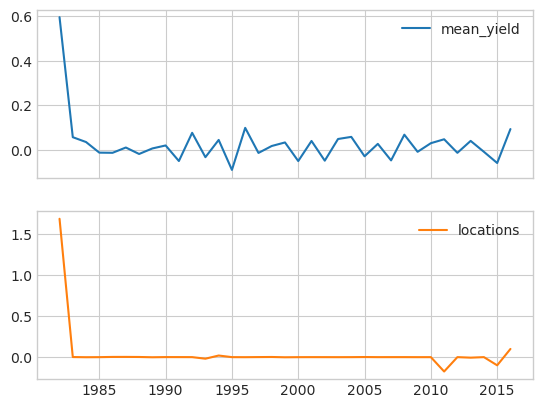

In [32]:

features_stationarity_pipeline.fit_transform(yields.copy()).plot(subplots=True);

### Feature Engineering Pipeline

In [33]:
def rolling_average_transformer(X: Union[pd.Series, pd.DataFrame], window: int = 5):
    """Compute the moving average with a length of 'window'."""

    if isinstance(X, pd.Series):
        X = X.to_frame()

    X_average = X.rolling(window=window).mean()
    X_average.columns = [f"{col}_rolling_average_{window}" for col in X.columns]

    logger.debug(f"rolling_average_transformer (transform): {X_average.shape}")

    return X_average


def rolling_std_transformer(X: Union[pd.Series, pd.DataFrame], window: int = 5):
    """Compute the moving standard deviation with a length of 'window'."""

    if isinstance(X, pd.Series):
        X = X.to_frame()

    X_std = X.rolling(window=window).std()
    X_std.columns = [f"{col}_rolling_std_{window}" for col in X.columns]

    logger.debug(f"rolling_std_transformer (transform): {X_std.shape}")

    return X_std


def rolling_median_transformer(X: Union[pd.Series, pd.DataFrame], window: int = 5):
    """Compute the moving median with a length of 'window'."""

    if isinstance(X, pd.Series):
        X = X.to_frame()

    X_median = X.rolling(window=window).median()
    X_median.columns = [f"{col}_rolling_median_{window}" for col in X.columns]

    logger.debug(f"rolling_median_transformer (transform): {X_median.shape}")

    return X_median


def time_series_shift(X: Union[pd.Series, pd.DataFrame], n_past: int = 5):
    """Function that gathers 'n_past' points to predict the point at time T_n."""

    if isinstance(X, np.ndarray):
        X = pd.DataFrame(X)
    if isinstance(X, pd.Series):
        X = X.to_frame()

    encoded_X = X.copy()
    for column in X.columns:
        for past_delta in range(1, n_past + 1):
            column_name = f"{column}_{past_delta}"
            X_delta = X[column].shift(past_delta)
            X_delta = X_delta.rename(column_name)

            encoded_X = pd.concat([encoded_X, X_delta], axis=1)

    # Now drop all the columns from time T_n. We want to keep at the feature level T_n-1, T_n-2, ... T_0 and predict the value at time T_n.
    encoded_X = encoded_X.drop(columns=X.columns)

    logger.debug(f"time_series_shift (transform): {encoded_X.shape}")

    return encoded_X

In [34]:
class DropRowsTransformer(BaseEstimator, TransformerMixin):
    """Transformer used to drop a given number of rows from the beginning of the DataFrame."""

    def __init__(self, num_rows: int):
        """

        Args:
            num_rows: The number of rows to drop at the beginning of the structure.
        """

        self.num_rows = num_rows
        self.start_X = None

    def fit(self, X: pd.DataFrame, y: Optional[Union[pd.DataFrame, pd.Series]] = None) -> "DropRowsTransformer":
        self.start_X = X.iloc[:self.num_rows]

        logger.debug(f"DropRowsTransformer X (fit): {X.shape}")
        if y is not None:
            logger.debug(f"DropRowsTransformer y (fit): {y.shape}")

        return self

    def transform(self, X: Union[np.ndarray, pd.Series, pd.DataFrame]) -> pd.DataFrame:
        if isinstance(X, np.ndarray):
            X = X[self.num_rows: ]
        else:
            X = X.iloc[self.num_rows: ]

        logger.debug(f"DropRowsTransformer (transform): {X.shape}")

        return X

    def inverse_transform(self, X: Union[np.ndarray, pd.Series, pd.DataFrame]) -> pd.DataFrame:
        if isinstance(X, np.ndarray):
            X = pd.DataFrame(X)

        X = pd.concat([self.start_X, X], axis=0)

        logger.debug(f"DropRowsTransformer (inverse_transform): {X.shape}")

        return X

In [35]:
RollingAverageTransformer = FunctionTransformer(partial(rolling_average_transformer, window=NUM_OBSERVED_POINTS))
RollingStdTransformer = FunctionTransformer(partial(rolling_std_transformer, window=NUM_OBSERVED_POINTS))
RollingMedianTransformer = FunctionTransformer(partial(rolling_median_transformer, window=NUM_OBSERVED_POINTS))
ShiftNumObservedPointsTransformer = FunctionTransformer(partial(time_series_shift, n_past=NUM_OBSERVED_POINTS))
ShiftOnePointTransformer = FunctionTransformer(partial(time_series_shift, n_past=1))

- 대부분 FunctionTransformer를 사용했다. fit, inverse_transform을 사용하지 않기 때문이다.  
- DropRowsTransformer는 사용하기 때문에 클래스로 구현했다.
- 대부분의 경우 FunctionTransformer를 사용하는 것이 효율적이다.

이제 다음을 사용하자.  
- make_column_transformer (a shortcut for ColumnTransfomer)
    - 컬럼별 다른 전처리 적용위해
- make_union (a shortcut for FeatureUnion)
    - 다수 피처를 병렬로 처리하기 위해

여기서는 다음 피처를 병렬로 적용하고자 한다. 
- past observations
- moving average
- moving standard deviation
- moving median

- `locations` 피처에 적용하려고 한다.  


아래 스니펫에서 이러한 구성 요소가 실제로 작동하는 것을 볼 수 있습니다. Sklearn 파이프라인 패러다임에 따라 파이프라인 전체에서 대부분의 기능을 얼마나 멋지게 재사용했는지 살펴보십시오.

또 다른 필수 요소는 memory="캐시" 속성입니다. 이 속성을 사용하면 모든 단계가 로컬 디스크에 캐시됩니다. 따라서 새로 실행할 때 출력이 캐시되면 캐시에서 자동으로 결과를 읽습니다. 또한 변경 사항이 있을 경우 언제 캐시를 무효화해야 하는지 알 수 있습니다.

In [36]:
def build_feature_engineering_pipeline() -> Pipeline:
    """Factory function used to build the feature engineering pipeline."""

    return make_pipeline(
        build_stationarity_pipeline(source="features"),
        make_column_transformer(
            (
                make_union(
                    ShiftNumObservedPointsTransformer,
                    make_pipeline(RollingAverageTransformer, ShiftOnePointTransformer),
                    make_pipeline(RollingStdTransformer, ShiftOnePointTransformer),
                    make_pipeline(RollingMedianTransformer, ShiftOnePointTransformer)
                ),
                ["mean_yield"]
            ),
            (
                make_union(
                    ShiftNumObservedPointsTransformer,
                    make_pipeline(RollingAverageTransformer, ShiftOnePointTransformer)
                ),
                ["locations"]
            ),

        ),
        BackFillImputer,
        ForwardFillImputer,
        DropRowsTransformer(num_rows=NUM_OBSERVED_POINTS),
        memory="cache",
        verbose=True
    )

In [37]:
feature_engineering_pipeline = build_feature_engineering_pipeline()
feature_engineering_pipeline

Pipeline(memory='cache',
         steps=[('pipeline',
                 Pipeline(memory='cache',
                          steps=[('functiontransformer-1',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='ffill'))),
                                 ('logtransfo...
                                                  ['locations'])])),
                ('functiontransformer-1',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                ('functiontransformer-2',
                 FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='ffill'))),
                ('droprowstransformer', DropRowsTransformer(num_rows=5))],
         verbose=True)

In [38]:
feature_engineered_yields = feature_engineering_pipeline.fit_transform(X_train.copy())
feature_engineered_yields

DEBUG:sklearn-pipelines:DropRowsTransformer X (fit): (31, 14)
DEBUG:sklearn-pipelines:DropRowsTransformer (transform): (26, 14)


[Pipeline]  (step 5 of 5) Processing droprowstransformer, total=   0.0s


,0,1,2,3,4,5,6,7,8,9,10,11,12,13
5,-0.013690,-0.013000,0.034739,0.056611,0.596868,0.132306,0.261484,0.034739,0.002453,-0.000238,-0.001108,0.001029,1.683205,0.337068
6,0.010093,-0.013690,-0.013000,0.034739,0.056611,0.014951,0.030628,0.010093,0.002683,0.002453,-0.000238,-0.001108,0.001029,0.000964
7,-0.018987,0.010093,-0.013690,-0.013000,0.034739,-0.000169,0.022502,-0.013000,0.001811,0.002683,0.002453,-0.000238,-0.001108,0.001120
8,0.005931,-0.018987,0.010093,-0.013690,-0.013000,-0.005931,0.013020,-0.013000,-0.001496,0.001811,0.002683,0.002453,-0.000238,0.001043
9,0.019365,0.005931,-0.018987,0.010093,-0.013690,0.000542,0.016267,0.005931,0.000551,-0.001496,0.001811,0.002683,0.002453,0.001200
10,-0.050680,0.019365,0.005931,-0.018987,0.010093,-0.006856,0.028311,0.005931,0.000394,0.000551,-0.001496,0.001811,0.002683,0.000789
11,0.076288,-0.050680,0.019365,0.005931,-0.018987,0.006383,0.047316,0.005931,0.000000,0.000394,0.000551,-0.001496,0.001811,0.000252
12,-0.033395,0.076288,-0.050680,0.019365,0.005931,0.003502,0.049630,0.005931,-0.019071,0.000000,0.000394,0.000551,-0.001496,-0.003924
13,0.044243,-0.033395,0.076288,-0.050680,0.019365,0.011164,0.052945,0.019365,0.019464,-0.019071,0.000000,0.000394,0.000551,0.000268
14,-0.090670,0.044243,-0.033395,0.076288,-0.050680,-0.010843,0.069091,-0.033395,-0.000079,0.019464,-0.019071,0.000000,0.000394,0.000142


In [39]:
print(feature_engineered_yields.shape)
print(X_train.shape)

(26, 14)
(32, 2)


### 3. Regressor Pipeline

In [40]:

def build_regressor_pipeline() -> Pipeline:
    """
    Factory function used to build the final regressor.
    One key thing is that the model (e.g., RandomForestRegressor) should always be the last unit within the pipeline.
    Otherwise, you can compose the transformations how you wish.
    """

    return make_pipeline(
        build_feature_engineering_pipeline(),
        MinMaxScaler(),
        RandomForestRegressor(n_estimators=100),
        memory="cache",
        verbose=True
    )

In [41]:

regressor_pipeline = build_regressor_pipeline()
regressor_pipeline

Pipeline(memory='cache',
         steps=[('pipeline',
                 Pipeline(memory='cache',
                          steps=[('pipeline',
                                  Pipeline(memory='cache',
                                           steps=[('functiontransformer-1',
                                                   FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                                                  ('functiontransformer-2',
                                                   FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7...
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='ffill'))),
                                 ('droprowstransformer',
                                  DropRowsTransformer(num_rows=5))],
                          verbose=True)),
                ('minmaxscaler', MinMaxScaler()),
                ('randomforestregressor', RandomForestRegressor())],
         verbose=True)

### 4. Target Pipeline

In [42]:
def build_target_pipeline() -> Pipeline:
    """Factory function used to build the target (e.g., y) pipeline."""

    return make_pipeline(
       build_stationarity_pipeline(source="target"),
       memory="cache",
       verbose=True
       )

In [43]:
target_pipeline = build_target_pipeline()

In [44]:
target_pipeline

Pipeline(memory='cache',
         steps=[('pipeline',
                 Pipeline(memory='cache',
                          steps=[('functiontransformer-1',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                                 ('functiontransformer-2',
                                  FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='ffill'))),
                                 ('logtransformer', LogTransformer()),
                                 ('differencetransformer',
                                  DifferenceTransformer(num_observed_points=0))],
                          verbose=True))],
         verbose=True)

Global Pipeline. Let's Put Things Together.

TransformedTargetRegressor를 사용한다.  
- regressor : 앞에서 사용한 regressor_pipeline를 사용  
- transformer : 파이프라인 내에 정의된 fit() 및 transform() 메서드를 사용할 때 모델이 기준 진실로 사용할 레이블을 전처리할 target_pipeline을 입력으로 받습니다. 또한 예측을 할 때 inverse_transform()을 호출하는 모델의 출력을 후처리합니다. 얼마나 멋진가요? 마지막으로, 모든 단계를 하나의 논리 단위로 묶는 방법입니다.

In [45]:
def build_global_pipeline() -> Pipeline:
    """Factor function used to build the final pipeline."""

    return make_pipeline(
        TransformedTargetRegressor(
            regressor=build_regressor_pipeline(),
            transformer=build_target_pipeline(),
            check_inverse=False
        ),
        memory="cache",
        verbose=True
    )

In [46]:
pipeline = build_global_pipeline()

In [47]:
pipeline

Pipeline(memory='cache',
         steps=[('transformedtargetregressor',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=Pipeline(memory='cache',
                                                               steps=[('pipeline',
                                                                       Pipeline(memory='cache',
                                                                                steps=[('pipeline',
                                                                                        Pipeline(memory='cache',
                                                                                                 steps=[('functiontransformer-1',
                                                                                                         FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, m...
                                                                                          FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                                                                                         ('functiontransformer-2',
                                                                                          FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='ffill'))),
                                                                                         ('logtransformer',
                                                                                          LogTransformer()),
                                                                                         ('differencetransformer',
                                                                                          DifferenceTransformer(num_observed_points=0))],
                                                                                  verbose=True))],
                                                                 verbose=True)))],
         verbose=True)

In [48]:
pipeline.named_steps

{'transformedtargetregressor': TransformedTargetRegressor(check_inverse=False,
                            regressor=Pipeline(memory='cache',
                                               steps=[('pipeline',
                                                       Pipeline(memory='cache',
                                                                steps=[('pipeline',
                                                                        Pipeline(memory='cache',
                                                                                 steps=[('functiontransformer-1',
                                                                                         FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                                                                                        ('functiontransformer-2',
                                                                                         FunctionTran

How to Use the Global Pipeline

학습

In [49]:
pipeline.fit(X = X_train.copy(), y= y_train.copy())

DEBUG:sklearn-pipelines:DifferenceTransformer X (fit): (27, 1)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (27, 1)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (27, 1)
DEBUG:sklearn-pipelines:LogTransformer (transform): (27, 1)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (26, 1)


[Pipeline]  (step 4 of 4) Processing differencetransformer, total=   0.0s
[Pipeline] .......... (step 1 of 1) Processing pipeline, total=   0.0s
[Pipeline]  (step 3 of 3) Processing randomforestregressor, total=   0.1s
[Pipeline]  (step 1 of 1) Processing transformedtargetregressor, total=   0.1s


Pipeline(memory='cache',
         steps=[('transformedtargetregressor',
                 TransformedTargetRegressor(check_inverse=False,
                                            regressor=Pipeline(memory='cache',
                                                               steps=[('pipeline',
                                                                       Pipeline(memory='cache',
                                                                                steps=[('pipeline',
                                                                                        Pipeline(memory='cache',
                                                                                                 steps=[('functiontransformer-1',
                                                                                                         FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, m...
                                                                                          FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='bfill'))),
                                                                                         ('functiontransformer-2',
                                                                                          FunctionTransformer(func=functools.partial(<function time_series_imputer at 0x7f5eb08c63b0>, method='ffill'))),
                                                                                         ('logtransformer',
                                                                                          LogTransformer()),
                                                                                         ('differencetransformer',
                                                                                          DifferenceTransformer(num_observed_points=0))],
                                                                                  verbose=True))],
                                                                 verbose=True)))],
         verbose=True)

In [50]:
y_pred = pipeline.predict(X_test.copy())
y_pred

DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (10, 2)
DEBUG:sklearn-pipelines:LogTransformer (transform): (10, 2)
DEBUG:sklearn-pipelines:DifferenceTransformer (transform): (9, 2)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 5)
DEBUG:sklearn-pipelines:rolling_average_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:rolling_std_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:rolling_median_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 5)
DEBUG:sklearn-pipelines:rolling_average_transformer (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_shift (transform): (9, 1)
DEBUG:sklearn-pipelines:time_series_imputer (transform): (9, 14)
DEBUG:sklearn-pipelines:

26    4.026584
0     4.043255
1     4.000883
2     4.028746
3     4.237074
Name: 0, dtype: float64

Test

In [51]:
SIZE_TEST_SPLIT

4

In [52]:
y_test[-4:]

2013    4.190502
2014    4.151844
2015    3.911601
2016    4.293674
Name: mean_yield, dtype: float32

In [53]:
y_test

2012    4.026584
2013    4.190502
2014    4.151844
2015    3.911601
2016    4.293674
Name: mean_yield, dtype: float32

In [54]:
def evaluate(y_test, y_pred):
    y_test = y_test.iloc[-SIZE_TEST_SPLIT:]
    y_pred = y_pred.iloc[-SIZE_TEST_SPLIT:]

    logger.info(f"RMSE: {mean_squared_error(y_test, y_pred, squared=False):.6f}")
    logger.info(f"MAPE: {mean_absolute_percentage_error(y_test, y_pred):.6f}")

In [55]:
evaluate(y_test, y_pred)

INFO:sklearn-pipelines:RMSE: 0.123893
INFO:sklearn-pipelines:MAPE: 0.028657
